# Предсказание выходной температуры сплава при плавке стали 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Кратко, процесс плавки представляет собой замер температуры, нагревание сплава электродами, добавление примесей, продувка газом и снова замер температуры. Процесс повторяется необходимое количество раз.  

**Цель работы:**  
Создать модель прогнозирования температуры сплава на последней итерации цикла плавки (задача регрессии). Исходные данные - техническая информация(циклы нагрева и мощность электродов, информация о примесях, продувке газом и пр.) для чуть более 3000 циклов плавки.  
Метрика качества - MAE. Она должна быть не выше 6.8.

**Ход работы**
1. Исследование данных
2. Предобработка данных
3. Выбор и исследование нескольких моделей машинного обучения
4. Тестирование наиболее подходящей модели
5. Создание отчета по итогам проведенной работы

**-----------PEP----------- не забыть**

# Исследование данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
RANDOM_STATE = 110923

Импортируем наши датасеты

In [5]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

except:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

Посмотрим на каждый из датасетов

## Data_arc

`data_arc` - это датасет с данными об электродах, которые опускают в ковш, для плавки находящегося в нем стального сплава

### Общая информация о датасете

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


---
Явные пропуски в датасете отсутсвуют, во всех колонках 14876 значений.  
`key` - это номер партии. Если есть несколько строк с одинаковым значением key, то это разные циклы обработки.  
Если смотреть на описательные статистики, то сразу заметно отрицательное значение в поле `Реактивная мощность`. Дальше, как раз взглянем на столбцы с мощностью подробнее.  
Также, на этапе предобработке можно будет сгенерировать новые признаки: длительность нагрева, полную мощность и энергию.

### Смотрим признаки

**Активная мощность**

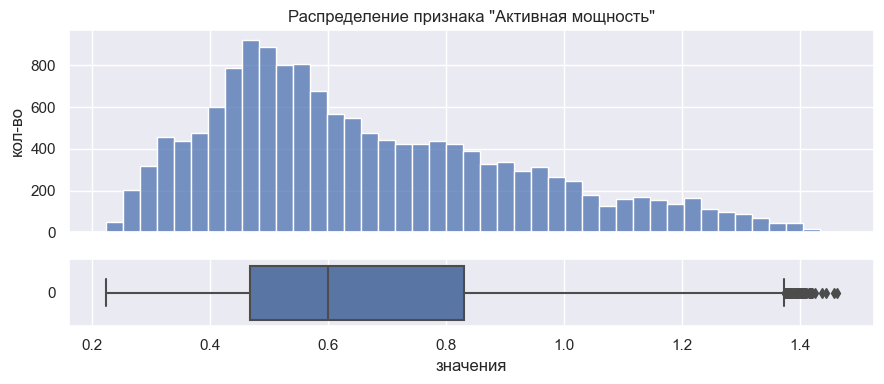

In [20]:
sns.set_theme()
fig, axes = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
sns.histplot(data_arc['Активная мощность'], ax=axes[0])
sns.boxplot(data_arc['Активная мощность'], orient='h', ax=axes[1])
axes[0].set(title='Распределение признака "Активная мощность"')
axes[0].set(ylabel='кол-во')
axes[1].set(xlabel='значения')
plt.tight_layout()

Распределение похоже на нормальное, со смещением вправо. Аномалий или аномальных пиков на графиике нет.  
На диаграмме размаха есть значения, которые можно посчитать выбросами. Но точно сказать, выбросы это или технологическая норма нельзя, да и находятся они не так уж и далеко от границы "уса". Поэтому, будем считать их нормой

**Реактивная мощность**

Чтобы графики сильно не смещались из-за аномальных значений, исследуем их отдельно. В нашем случае, это отрицательные значения

In [36]:
print('Отрицательных значений:', len(data_arc[data_arc['Реактивная мощность'] < 0]))

Отрицательных значений: 1


Отлично, можно смело строить графики без этого выброса

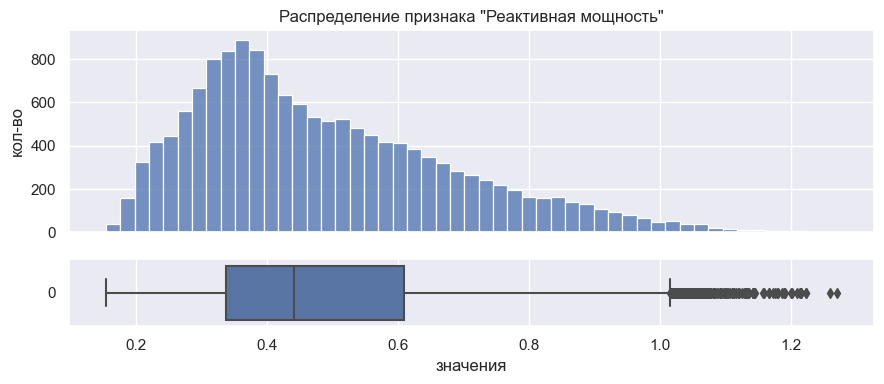

In [43]:
#уберем выброс, чтобы графики нормально отображались
data_react = data_arc[data_arc['Реактивная мощность'] > 0]

fig, axes = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
sns.histplot(data_react['Реактивная мощность'], ax=axes[0])
sns.boxplot(data_react['Реактивная мощность'], orient='h', ax=axes[1])
axes[0].set(title='Распределение признака "Реактивная мощность"')
axes[0].set(ylabel='кол-во')
axes[1].set(xlabel='значения')
plt.tight_layout()

Получили распределение, близкое к нормальному со смещением вправо. Выброс всего один - отрицательное значение. Данные, лежащие за границей правого "уса" выбросами считать не будем.

## Data_bulk

`data_bulk` - это датасет с данными о подаче сыпучих материалов (объём)

### Общая информация о датасете

In [6]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Имеем от заказчика информацию - отсутствующие значения можно считать нулевыми(то есть, материал не добавлялся)  
Думаю, не очень целесообразно рассматривать признаки, где нулевых значений слишком много. Возьмем только те столбцы, где больше 1000 значений.

In [13]:
bulk_selected = ['Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14', 'Bulk 15']

In [14]:
data_bulk[bulk_selected].head()

,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,NaN,43.0,206.0,150.0,154.0
1,NaN,73.0,206.0,149.0,154.0
2,NaN,34.0,205.0,152.0,153.0
3,NaN,81.0,207.0,153.0,154.0
4,NaN,78.0,203.0,151.0,152.0


In [15]:
data_bulk[bulk_selected].describe()

,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
count,1298.000000,1014.000000,2450.000000,2806.000000,2248.000000
mean,113.879045,104.394477,260.471020,170.284747,160.513345
std,75.483494,48.184126,120.649269,65.868652,51.765319
min,6.000000,12.000000,53.000000,16.000000,1.000000
25%,58.000000,72.000000,204.000000,119.000000,105.000000
50%,97.500000,102.000000,208.000000,151.000000,160.000000
75%,152.000000,133.000000,316.000000,205.750000,205.000000
max,454.000000,281.000000,1849.000000,636.000000,405.000000


В столбце `Bulk 12` видны выбивающиеся высокие значения. Если таких значений мало, исключим их при постройке графика

In [43]:
print('Аномальных значений:', len(data_bulk[data_bulk['Bulk 12'] > 800]))

Аномальных значений: 3


### Смотрим признаки

In [45]:
data_bulk12 = data_bulk[data_bulk['Bulk 12'] < 800]

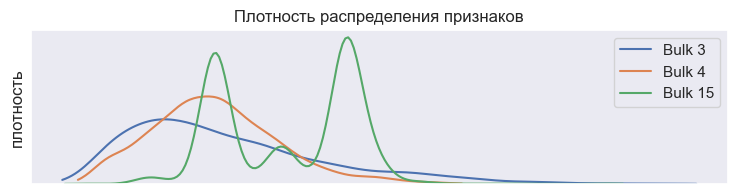

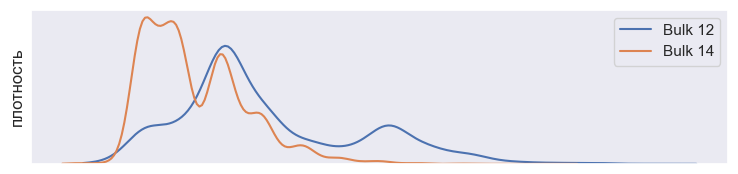

In [53]:
plt.figure(figsize=(9, 2))
plt.title('Плотность распределения признаков')
fig = sns.kdeplot(data_bulk['Bulk 3'], cut=True)
fig = sns.kdeplot(data_bulk['Bulk 4'], cut=True)
fig = sns.kdeplot(data_bulk['Bulk 15'], cut=True)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('плотность')
plt.legend(labels=['Bulk 3', 'Bulk 4', 'Bulk 15'])
plt.show()
plt.figure(figsize=(9, 2))
fig = sns.kdeplot(data_bulk12['Bulk 12'], cut=True)
fig = sns.kdeplot(data_bulk['Bulk 14'], cut=True)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('плотность')
plt.legend(labels=['Bulk 12', 'Bulk 14'])
plt.show()

Видно, что признаки распределены по-разному, но у всех есть смещение вправо.  
Выбросами будем считать только несколько экстремально высоких значений стобца `Bulk 12`

## Data_gas

`data_gas` - это датасет с данными о продувке сплава газом

In [55]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [56]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [65]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [68]:
print('Аномальных значений:', len(data_gas[data_gas['Газ 1'] >= 40]))

Аномальных значений: 8


In [69]:
data_gas_selected = data_gas[data_gas['Газ 1'] < 40]

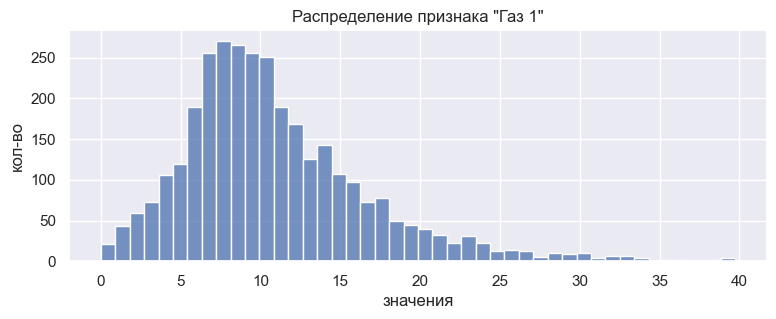

In [74]:
plt.figure(figsize=(9, 3))
sns.histplot(data_gas_selected['Газ 1'])
plt.xlabel('значения')
plt.ylabel('кол-во')
plt.title('Распределение признака "Газ 1"')
plt.show()

Получили распределение без аномалий

## Data_temp

`data_temp` - это датасет с результатами измерения температуры сплава в ковше

In [75]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [77]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Записи с одинаковым значением поля `key` - это разные итерации одного цикла плавки.  
Температура на первой итерации можеть быть признаком для обучения.  
Температура на последней итерации - таргет

In [78]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


От заказчика знаем, что температуру ниже ~1450 можем считать дефектом измерения, так как плавка сплава при такой температуре невозможна

In [80]:
data_temp_selected = data_temp[data_temp['Температура'] > 1450]

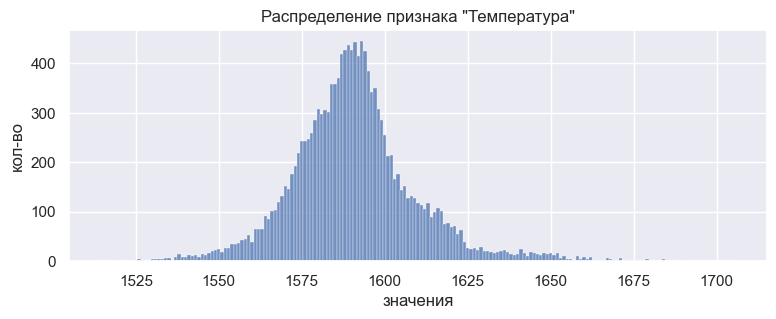

In [82]:
plt.figure(figsize=(9, 3))
sns.histplot(data_temp_selected['Температура'], discrete=True)
plt.xlabel('значения')
plt.ylabel('кол-во')
plt.title('Распределение признака "Температура"')
plt.show()

## Data_wire

`data_wire` - это датасет с данными о подаче проволочных материалов (объём)

In [83]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Как и в случае с сыпучими материалами имеем информацию от заказчика, что отсутствующие значения можно заполнить нулями.  
Рассмотрим только те столбцы, где значений больше 1000

In [87]:
data_wire[['Wire 1', 'Wire 2']].head()

,Wire 1,Wire 2
0,60.059998,NaN
1,96.052315,NaN
2,91.160157,NaN
3,89.063515,NaN
4,89.238236,9.11456


In [88]:
data_wire[['Wire 1', 'Wire 2']].describe()

,Wire 1,Wire 2
count,3055.000000,1079.000000
mean,100.895853,50.577323
std,42.012518,39.320216
min,1.918800,0.030160
25%,72.115684,20.193680
50%,100.158234,40.142956
75%,126.060483,70.227558
max,330.314424,282.780152


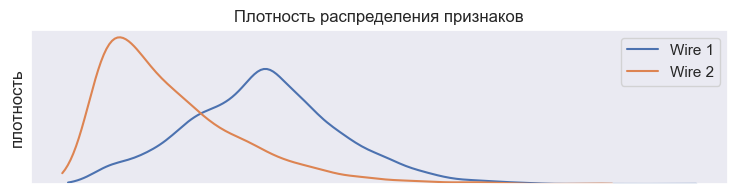

In [95]:
plt.figure(figsize=(9, 2))
plt.title('Плотность распределения признаков')
fig = sns.kdeplot(data_wire['Wire 1'], cut=True)
fig = sns.kdeplot(data_wire['Wire 2'], cut=True)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('плотность')
plt.legend(labels=['Wire 1', 'Wire 2'])
plt.show()

Получили распределения без аномалий

## Data_bulk_time и data_wire_time

`data_bulk_time` и `data_wire_time` - это датасет с временем добавления сыпучих и проволочных материалов соответственно

In [104]:
data_bulk_time.sample(5, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
435,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-21 03:31:46,NaN,2019-05-21 03:25:53,NaN,2019-05-21 03:18:46,2019-05-21 02:13:39
673,705,NaN,NaN,2019-05-31 00:03:29,2019-05-30 23:55:55,NaN,2019-05-30 23:50:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-30 23:38:26,NaN
1511,1569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-01 12:01:41,NaN,2019-07-01 11:57:58,2019-07-01 11:32:28
2973,3082,NaN,NaN,2019-09-01 06:42:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 06:52:52,NaN,2019-09-01 06:49:35,2019-09-01 06:42:21
2526,2622,NaN,NaN,2019-08-15 03:06:59,NaN,NaN,2019-08-15 03:36:05,NaN,NaN,NaN,NaN,2019-08-15 03:24:52,NaN,NaN,2019-08-15 03:12:31,NaN


In [105]:
data_wire_time.sample(5, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2141,2251,2019-08-01 13:50:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,190,2019-05-10 19:48:29,2019-05-10 19:41:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,1208,2019-06-18 04:50:43,2019-06-18 04:45:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2901,3060,2019-08-31 14:02:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651,1731,2019-07-06 20:21:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Эти датафреймы в работе использоваться не будут, так как у нас задача регрессии, а не прогнозирования временных рядов

## Результаты исследования данных (вывод)

Подведем итог по исследованным датасетам:
* `data_arc` - убрать единичный выброс, сгенерировать новые признаки
* `data_bulk` - отсутствующие значения заполнить нулями, выбрать для обучения целесообразные признаки, убрать единичные выбросы
* `data_gas` - убрать единичные выбросы
* `data_temp` - удалить пропуски, агрегировать по номеру цикла(температура на первой итерации - фича, температура на последней итерации - таргет), удалить слиишком низкую температуру, удалить циклы, состоящий из 1 итерации
* `data_wire` - отсутствующие значения заполнить нулями, выбрать для обучения целесообразные признаки
* `data_bulk_time` и `data_wire_time` - не используются  

Также, требование заказчика: 
> При удалении производственного цикла из любого датасета, считать такой цикл дефектным. Соответсвенно, удалить его из всех остальных датасетов

## План работы

1. Загрузка данных
2. Исследуем каждый датасет
    * Общая информация
    * Описательные статистики
    * Несколько строк датасета
    * Распределение признаков
3. Предобработка
    * Убираем из датасетов аномалии:
        - отрицательная реактивная мощность
        - слишком низкая температура
        - отсутсвие температуры
        - циклы, в которых всего 1 итерация нагрева
        - признаки, где большинство значений пропущено (data_bulk и data_wire)
    * Заполняем пропуски нулями (data_bulk и data_wire)
    * Генерируем новые признаки (data_arc)
    * Получаем температуру-признак и температуру-таргет (data_temp)
    * Объединяем датасеты в один датафрейм
    * Исследуем итоговый датафрейм(корреляция признаков)
    * Разделяем на train/test выборки
    * На train выборке удаляем выбросы
4. Выбор и проверка моделей
    * Выбираем несколько моделей для изучения
    * Если нужно масштабировать данные, делаем pipeline
    * Подбираем гиперпараметры(gridsearch)
    * Если подбирать гиперпараметры не нужно, используем cross_val_score
    * Отбираем лучшую модель (лучший средний результат на кросс-валидации)
5. Тестируем итоговую модель
    * Тестируем лучшую модель на test выборке
    * Сравниваем модель с константной
    * Исследуем важность признаков
6. отчет о проделанной работе

# Предобработка данных

## Data_arc

Сначала уберем выброс

In [107]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [127]:
keys_to_remove = []
keys_to_remove.append(data_arc.loc[data_arc['Реактивная мощность'] < 0, 'key'].values[0])
data_arc.query('key == @keys_to_remove[0]')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [179]:
df_arc = data_arc[~data_arc['key'].isin(keys_to_remove)].copy()

In [180]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

df_arc['duration'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.total_seconds().astype('int16')
df_arc['apparent power'] = df_arc.apply(lambda x: np.hypot(x['Активная мощность'], x['Реактивная мощность']), axis=1)
df_arc['energy'] = df_arc['apparent power'] * df_arc['duration']

df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,duration,apparent power,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,159.830252


In [181]:
df_arc = df_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
df_arc.shape

(14872, 6)

In [182]:
df_arc = df_arc.groupby('key', sort=False, as_index=False).sum()
df_arc.head()

,key,Активная мощность,Реактивная мощность,duration,apparent power,energy
0,1,3.036730,2.142821,1098,3.718736,770.282114
1,2,2.139408,1.453357,811,2.588349,481.760005
2,3,4.063641,2.937457,655,5.019223,722.837668
3,4,2.706489,2.056992,741,3.400038,683.455597
4,5,2.252950,1.687991,869,2.816980,512.169934
